In [6]:
# This file contains the code for the SIR model for the spread of a disease in a town having 5 localities

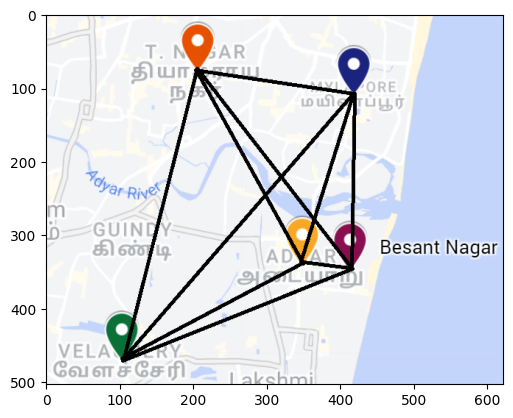

In [39]:
import matplotlib.pyplot as plt
import numpy as np

'''
Localilty1 --> Adyar
Localilty2 --> Besant Nagar
Localilty3 --> T.Nagar
Localilty4 --> Mylapore
Localilty5 --> Velachery

adyar --> besant nagar distance = 5.5 km 
adyar --> t.nagar distance = 8.5 km
adyar --> mylapore distance = 6.5 km
adyar --> velachery distance = 7.5 km
besant nagar --> mylapore distance = 4.5 km
besant nagar --> velachery distance = 6.5 km
besant nagar --> t.nagar distance = 6.5 km
t.nagar --> mylapore distance = 5.5 km
t.nagar --> velachery distance = 4.5 km
mylapore --> velachery distance = 4.5 km

mean distance = 6.1 km
std deviation = 1.5 km

Assuming that the rate of people travelling between each of these localities is roughly the same, 
the values of transport matrix can be represented as inverse of the distances between the localities:
transport_matrix = [[0, 0.18, 0.12, 0.15, 0.13],
                    [0.18, 0, 0.22, 0.11, 0.15],
                    [0.12, 0.22, 0, 0.18, 0.22],
                    [0.15, 0.11, 0.18, 0, 0.22],
                    [0.13, 0.15, 0.22, 0.22, 0]]

'''
chennai_map = plt.imread('Chennai map.png')
plt.imshow(chennai_map)
plt.show()


In [135]:
# Class to store the state of a locality
class locality:
    def __init__(self, infected, susceptible): 
        self.infected = infected
        self.susceptible = susceptible
        self.recovered = 0
    def __str__(self): # for printing the state of the locality
        return "Infected: " + str(self.infected) + ", Susceptible: " + str(self.susceptible) 
    
# Parameters
RECOVERY_RATE = 0.5
INFECTION_RATE =  0.8
DAYS = 20
Q_THRESHOLD = 0.3

# initialising the localities
loc1 = locality(5, 147143)       # adyar = 147143 people
loc2 = locality(5, 35115)       # besant nagar = 35115 people
loc3 = locality(5, 205000)       # t.nagar = 205000 people 
loc4 = locality(5, 111409)       # mylapore = 111409 people
loc5 = locality(5, 143991)       # velachery = 143991 people

# list of localities
localities = [loc1, loc2, loc3, loc4, loc5]

# function to transport people from locality i to locality j
def naive_transport(locality1, locality2, transport_matrix,i,j):
    transport_rate = transport_matrix[i][j]
    temp1 = int(locality2.infected * transport_rate)
    temp2 = int(locality2.susceptible * transport_rate)

    locality1.infected += temp1
    locality2.infected -= temp1
    locality1.susceptible += temp2
    locality2.susceptible -= temp2

def quarantined_transport(locality1, locality2, transport_matrix, i, j):
    # function to transport only uninfected people from locality i to locality j
    transport_rate = transport_matrix[i][j]
    locality1.susceptible -=  int(locality2.susceptible * transport_rate)
    locality2.susceptible += int(locality2.susceptible * transport_rate)

def infection(locality, infection_rate):    
    # function to infect people in a locality
    temp = int(locality.susceptible * infection_rate)
    locality.susceptible -= temp
    locality.infected += temp

def herd_immunity(locality, herd_immunity_rate):
    # function to make people immune to the disease in a locality
    temp = int(locality.susceptible * herd_immunity_rate)
    locality.susceptible -= temp
    locality.recovered += temp

def recovery(locality, recovery_rate):
    # function to recover people in a locality
    temp = int(locality.infected * recovery_rate)
    locality.infected -= temp
    locality.recovered += temp

# def generate_tm():
#     # transport_matrix = np.zeros((5,5))
#     # for a in range(5):
#     #     for b in range(5):
#     #         if a != b:
#     #             transport_matrix[a][b] = random.random()

#     transport_matrix = np.full((5,5), 0.2)
#     for t in range(5):
#         transport_matrix[t][t] = 0
#     return transport_matrix

def generate_tm():
    transport_matrix = [[0, 0.18, 0.12, 0.15, 0.13],
                        [0.18, 0, 0.22, 0.11, 0.15],
                        [0.12, 0.22, 0, 0.18, 0.22],
                        [0.15, 0.11, 0.18, 0, 0.22],
                        [0.13, 0.15, 0.22, 0.22, 0]]
    return transport_matrix

# the no. of people transported from locality i to locality j is calculated 
# as the product of the infected population in locality i and the proximity
# between locality i and locality j

def update_populations(localities, infection_rate, transport_method_obj):
    for i in range(len(localities)):
        for j in range(len(localities)):
            if i != j:
                if transport_method_obj == naive_transport:
                    transport_method_obj(localities[i], localities[j], generate_tm(), i, j)
                elif transport_method_obj == quarantined_transport and localities[i].susceptible > 0:
                    transport_method_obj(localities[i], localities[j], generate_tm(), i, j)
                if localities[j].susceptible > 0:
                    infection(localities[j], infection_rate)
                recovery(localities[j], RECOVERY_RATE)
                
    return localities

def simulate(localities, infection_rate, days, quarantine_thresh = 0.5, herd_immunity_rate = 0.1, imu_thresh = 0.7):
    for i in range(days):
        # print to check the working of the model 

        # print("Day " + str(i) + ":")
        # for locality in localities:
        #     print(locality)
        # print()
        
        sim_frac = i/days
        if sim_frac < quarantine_thresh:
            localities = update_populations(localities, infection_rate, naive_transport)
        elif sim_frac > quarantine_thresh:
            localities = update_populations(localities, infection_rate, quarantined_transport)
        elif sim_frac > imu_thresh:
            for locality in localities:
                herd_immunity(locality, herd_immunity_rate)
        yield localities

history = simulate(localities, INFECTION_RATE, DAYS, Q_THRESHOLD)

sus = []
inf = []
rec = []

# Plotting the results
for i in range(DAYS):
    for count in range(len(localities)):
        sus.append(localities[count].susceptible)
        inf.append(localities[count].infected)
        rec.append(localities[count].recovered)
    localities = next(history)
    


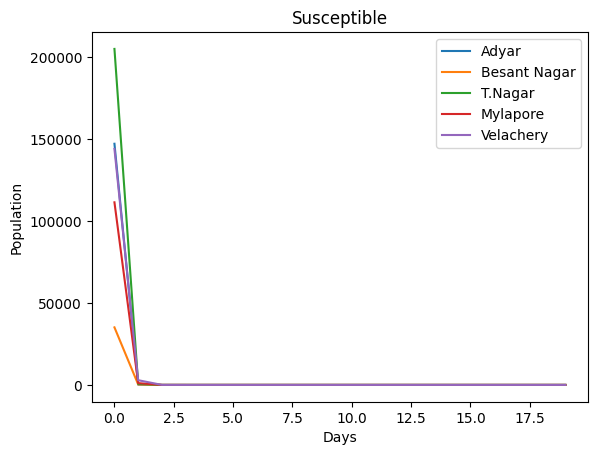

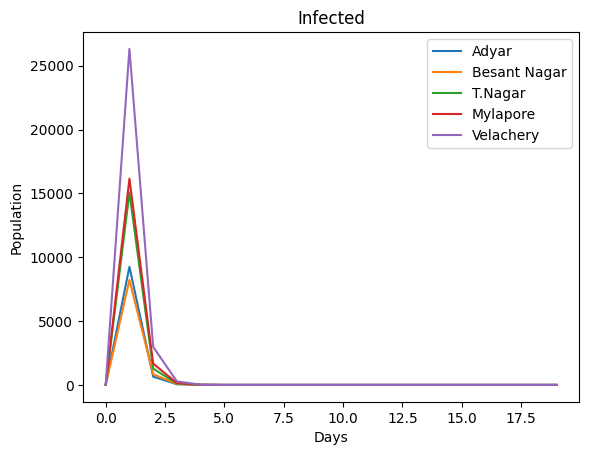

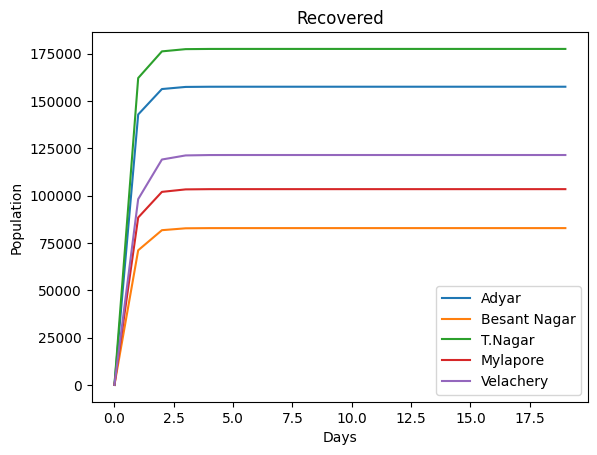

In [136]:
import pandas as pd

# reshaping the data for plotting
sus = (np.array(sus)).reshape(DAYS, 5)
inf = (np.array(inf)).reshape(DAYS, 5)
rec = (np.array(rec)).reshape(DAYS, 5)

sus = pd.DataFrame(sus)
inf = pd.DataFrame(inf)
rec = pd.DataFrame(rec)

#plotting the susceptible population
plt.plot(sus[0], label="Adyar")
plt.plot(sus[1], label="Besant Nagar")
plt.plot(sus[2], label="T.Nagar")
plt.plot(sus[3], label="Mylapore")
plt.plot(sus[4], label="Velachery")
plt.title("Susceptible")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.show()

#plotting the infected population
plt.plot(inf[0], label="Adyar")
plt.plot(inf[1], label="Besant Nagar")
plt.plot(inf[2], label="T.Nagar")
plt.plot(inf[3], label="Mylapore")
plt.plot(inf[4], label="Velachery")
plt.title("Infected")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.show()

# plotting the recovered population
plt.plot(rec[0], label="Adyar")
plt.plot(rec[1], label="Besant Nagar")
plt.plot(rec[2], label="T.Nagar")
plt.plot(rec[3], label="Mylapore")
plt.plot(rec[4], label="Velachery")
plt.title("Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.show()




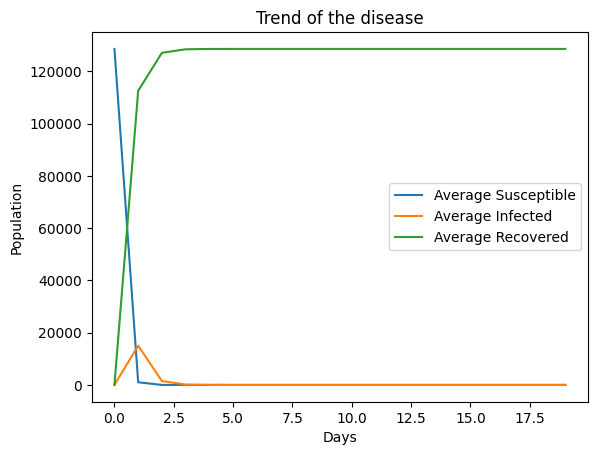

In [137]:
sus_mean = pd.Series.mean(sus, axis=1)
inf_mean = pd.Series.mean(inf, axis=1)
rec_mean = pd.Series.mean(rec, axis=1)

plt.plot(sus_mean, label="Average Susceptible")
plt.plot(inf_mean, label="Average Infected")
plt.plot(rec_mean, label="Average Recovered")
plt.title("Trend of the disease")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.show()

# inshallah boys played well